<a href="https://colab.research.google.com/github/Farmhouse121/Financial-Data-Science-in-Python/blob/main/Alphas/Filter_Rules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Investigation of Filter Rules
---
## Load useful packages...

In [1]:
from my_library import *

16:02:47 Starting...
16:02:47 Installing yfinance into Google notebook...
16:02:56 Installing arch into Google notebook...
16:03:04 Initialized.


## Get S&P 500 Index Data from Yahoo! Finance

In [2]:
nprint("Fetching data from Yahoo!...")
data,sname=download(ticker:='SPY','1990-01-02','2019-12-31',auto_adjust=True,progress=False),'S&P 500 Index ETF'
data.columns=data.columns.get_level_values(0)
data.columns.name=ticker
data.index=pd.PeriodIndex(data.index,freq='B')
data['Return']=data['Close'].pct_change()*hundred
data.dropna(inplace=True)
display(data)

16:03:04 Fetching data from Yahoo!...


<ipython-input-2-eadee26bc247>:5: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  data.index=pd.PeriodIndex(data.index,freq='B')


SPY,Close,High,Low,Open,Volume,Return
Date,,,,,,
1993-02-01,24.700508,24.700508,24.543513,24.543513,480500,0.711245
1993-02-02,24.752853,24.770297,24.630746,24.683078,201300,0.211920
1993-02-03,25.014500,25.031944,24.770286,24.787729,529400,1.057035
1993-02-04,25.119179,25.171510,24.822633,25.101735,531500,0.418474
1993-02-05,25.101728,25.154060,24.962177,25.101728,492100,-0.069470
...,...,...,...,...,...,...
2019-12-23,297.810944,298.209600,297.662600,298.153975,52990000,0.152764
2019-12-24,297.820160,298.089006,297.514193,298.042661,20270000,0.003095
2019-12-26,299.405609,299.414889,298.200359,298.209611,30911200,0.532351


## Fit baseline AR(1) GJR-AGARCH(1,1) model

In [3]:
from arch.univariate import ARX
model = ARX(data['Return'],lags=1)
model.volatility = GARCH2(0,1,1)
model.distribution = GeneralizedError2()
fit=model.fit(update_freq=0,disp='off')
nprint(fit.summary(),sep='\n')
display(baseline:=pd.DataFrame([fit.params,fit.std_err]).T)
data['Volatility']=fit.conditional_volatility
data['Alpha']=baseline.loc['Const','params']+baseline.loc['Return[1]','params']*data['Return'].shift()
data['Z Score']=(data['Return']-data['Alpha'])/data['Volatility'].shift()
display(data)
nprint("Baseline IC %.2f %%." % (hundred*fit.rsquared**half))

16:03:06
                               AR - GJR-GARCH Model Results                               
Dep. Variable:                             Return   R-squared:                       0.003
Mean Model:                                    AR   Adj. R-squared:                  0.003
Vol Model:                              GJR-GARCH   Log-Likelihood:               -8759.18
Distribution:      Generalized Error Distribution   AIC:                           17530.4
Method:                        Maximum Likelihood   BIC:                           17571.3
                                                    No. Observations:                 6777
Date:                            Fri, Mar 21 2025   Df Residuals:                     6775
Time:                                    16:03:05   Df Model:                            2
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
--------------

,params,std_err
Const,0.062285,0.009124
Return[1],-0.037913,0.013214
omega,0.017252,0.003156
gamma[1],0.187392,0.021784
beta[1],0.888962,0.011779
nu,1.348243,0.036889


SPY,Close,High,Low,Open,Volume,Return,Volatility,Alpha,Z Score
Date,,,,,,,,,
1993-02-01,24.700508,24.700508,24.543513,24.543513,480500,0.711245,NaN,NaN,NaN
1993-02-02,24.752853,24.770297,24.630746,24.683078,201300,0.211920,0.783950,0.035319,NaN
1993-02-03,25.014500,25.031944,24.770286,24.787729,529400,1.057035,0.750725,0.054250,1.279144
1993-02-04,25.119179,25.171510,24.822633,25.101735,531500,0.418474,0.719902,0.022209,0.527843
1993-02-05,25.101728,25.154060,24.962177,25.101728,492100,-0.069470,0.691350,0.046419,-0.160979
...,...,...,...,...,...,...,...,...,...
2019-12-23,297.810944,298.209600,297.662600,298.153975,52990000,0.152764,0.484160,0.045663,0.216694
2019-12-24,297.820160,298.089006,297.514193,298.042661,20270000,0.003095,0.475010,0.056493,-0.110290
2019-12-26,299.405609,299.414889,298.200359,298.209611,30911200,0.532351,0.467297,0.062167,0.989841


16:03:06 Baseline IC 5.46 %.


## Fit a Basic "Filter Rules" Model

In [4]:
# create filter rules summary holder, re-run this cell to reset dataframe
from itertools import product
summary=pd.DataFrame({tuple(x):[] for x in product(['Active','Inactive'],['Mean','St.Dev.','Count','Std.Err.'])},index=pd.Series([],name='Filter'))

16:03:06 Creating filter rule indicators with order 3 and offset 0.100000.
16:03:06 Conditional returns:


SPY,Close,High,Low,Open,Volume,Return,Volatility,Alpha,Z Score,Direction,...,Z_3,Direction_3,Filter_000,Filter_001,Filter_010,Filter_011,Filter_100,Filter_101,Filter_110,Filter_111
Date,,,,,,,,,,,,,,,,,,,,,
1993-02-01,24.700508,24.700508,24.543513,24.543513,480500,0.711245,NaN,NaN,NaN,0.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-02-02,24.752853,24.770297,24.630746,24.683078,201300,0.211920,0.783950,0.035319,NaN,0.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-02-03,25.014500,25.031944,24.770286,24.787729,529400,1.057035,0.750725,0.054250,1.279144,1.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-02-04,25.119179,25.171510,24.822633,25.101735,531500,0.418474,0.719902,0.022209,0.527843,1.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-02-05,25.101728,25.154060,24.962177,25.101728,492100,-0.069470,0.691350,0.046419,-0.160979,-1.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,297.810944,298.209600,297.662600,298.153975,52990000,0.152764,0.484160,0.045663,0.216694,1.0,...,-0.104065,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2019-12-24,297.820160,298.089006,297.514193,298.042661,20270000,0.003095,0.475010,0.056493,-0.110290,-1.0,...,0.672907,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2019-12-26,299.405609,299.414889,298.200359,298.209611,30911200,0.532351,0.467297,0.062167,0.989841,1.0,...,0.775036,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Active                               Inactive                      \
            Count      Mean   St.Dev.  Std.Err.    Count      Mean   St.Dev.   
Rule                                                                           
Filter_000  590.0  0.206878  1.566587  0.064495   6188.0  0.027767  1.092095   
Filter_101  598.0  0.102462  1.025833  0.041949   6180.0  0.037639  1.152783   
Filter_110  671.0  0.055102  0.928622  0.035849   6107.0  0.042067  1.163366   
Filter_001  642.0  0.053380  1.297860  0.051222   6136.0  0.042309  1.124815   
Filter_011  604.0  0.031708  0.981934  0.039954   6174.0  0.044498  1.156782   
Filter_100  669.0 -0.010807  1.254633  0.048507   6109.0  0.049289  1.129194   
Filter_010  620.0 -0.016509  1.187713  0.047700   6158.0  0.049385  1.137474   
Filter_111  586.0 -0.031905  0.921588  0.038070   6192.0  0.050481  1.160749   

                       Z Score  
            Std.Err.            
Rule                            
Filter_000  0.013883  2.714927  
Filter_101  0.014664  1.458711  
Filter_110  0.014887  0.335788  
Filter_001  0.014359  0.208111  
Filter_011  0.014722 -0.300367  
Filter_100  0.014447 -1.187388  
Filter_010  0.014495 -1.321759  
Filter_111  0.014751 -2.017848

<ipython-input-5-1e47dad24dc4>:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(x,rotation=90,fontsize=12)


16:03:10 Saved figure to '/content/drive/MyDrive/Subsequent Return Associated with Filter Rules.png'.


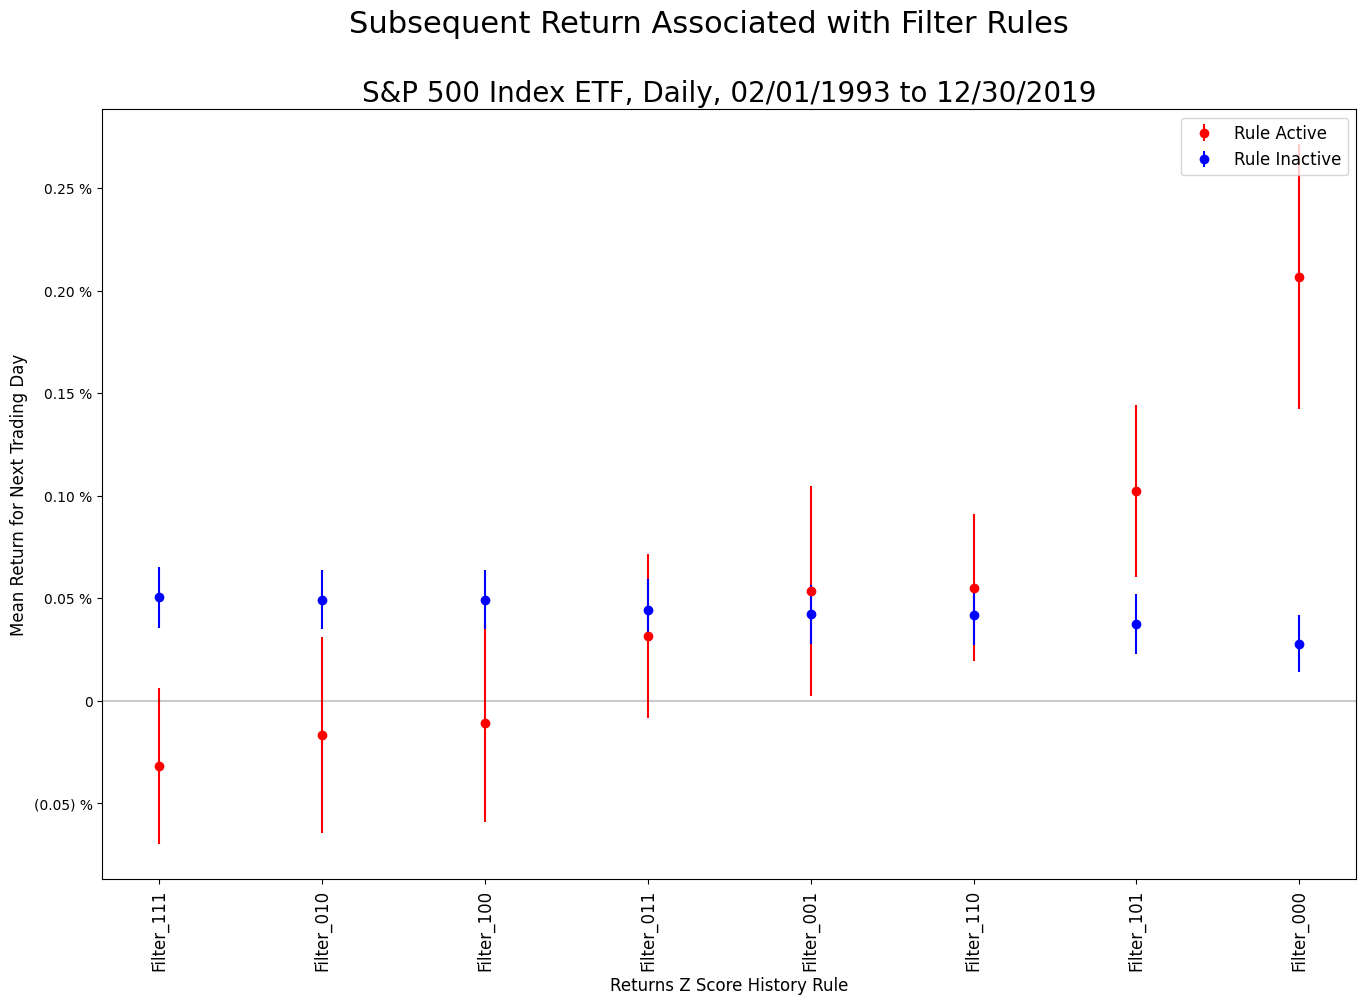

In [5]:
nprint("Creating filter rule indicators with order {:d} and offset {:f}.".format(forder:=3,foffset:=0.1))

data['Direction']=data['Z Score'].apply(lambda x: one if x>foffset else -one if x<-foffset else zero)
data.drop(data.columns[data.columns.str.contains('Filter')],axis=1,inplace=True)

for lag in range(1,forder+1):
    data['Z_'+str(lag)]=data['Z Score'].shift(lag)
    data['Direction_'+str(lag)]=data['Direction'].shift(lag)

for rule in range(2**forder):
    rmap=list(map(lambda x:-one if x=='0' else +one,label:="{:0#b}".replace("#",str(forder)).format(rule)))
    data['Filter_'+label]=(data['Direction_1']==rmap[0])

    for lag in range(2,forder+1):
        data['Filter_'+label]&=(data['Direction_'+str(lag)]==rmap[lag-1])

    data['Filter_'+label]=data['Filter_'+label].apply(lambda x:one if x else zero)

nprint("Conditional returns:")
display(data)

for f in data.columns[data.columns.str.contains('Filter')]:
    g=data[[f,'Return']].groupby(f)
    summary.loc[f,('Active','Mean')]=g.mean().loc[one,'Return']
    summary.loc[f,('Inactive','Mean')]=g.mean().loc[zero,'Return']
    summary.loc[f,('Active','St.Dev.')]=g.std().loc[one,'Return']
    summary.loc[f,('Inactive','St.Dev.')]=g.std().loc[zero,'Return']
    summary.loc[f,('Active','Count')]=g.count().loc[one,'Return']
    summary.loc[f,('Inactive','Count')]=g.count().loc[zero,'Return']

    for s in [c for c in set(summary.columns.get_level_values(0)) if c!='Z Score']:
        summary.loc[f,(s,'Std.Err.')]=summary.loc[f,(s,'St.Dev.')]/np.sqrt(summary.loc[f,(s,'Count')])

summary=summary[sorted(summary.columns)].copy()
summary['Z Score']=(summary['Active','Mean']-summary['Inactive','Mean'])/np.sqrt(summary['Active','Std.Err.']**two+summary['Inactive','Std.Err.']**two)
summary.index.name='Rule'
display(summary.sort_values('Z Score',ascending=False))

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.errorbar(x:=summary.sort_values('Z Score').index,y:=summary.loc[x,('Active','Mean')],ye:=summary.loc[x,('Active','Std.Err.')],fmt='o',color='red',label='Rule Active')
plot.errorbar(x,y:=summary.loc[x,('Inactive','Mean')],ye:=summary.loc[x,('Inactive','Std.Err.')],fmt='o',color='blue',label='Rule Inactive')
plot.set_xticklabels(x,rotation=90,fontsize=12)
plot.set_ylabel('Mean Return for Next Trading Day',fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(2))
plot.set_xlabel('Returns Z Score History Rule',fontsize=12)
plot.axhline(color='black',alpha=0.2)
figure.suptitle(title:='Subsequent Return Associated with Filter Rules',fontsize=22)
plot.set_title(subtitle:='{:s}, Daily, {:s} to {:s}'.format(sname,data.index[0].strftime("%m/%d/%Y"),data.index[-1].strftime("%m/%d/%Y")),fontsize=20)
plot.legend(fontsize=12)
figure.savefig(filename:=(filepath:='/content/drive/MyDrive/')+title+'.png',dpi=300,bbox_inches='tight')
nprint("Saved figure to '{:s}'.".format(filename))

16:19:36 Fitting GJR-GARCH model with filter rules...
16:19:36
                              AR-X - GJR-GARCH Model Results                              
Dep. Variable:                             Return   R-squared:                       0.002
Mean Model:                                  AR-X   Adj. R-squared:                  0.001
Vol Model:                              GJR-GARCH   Log-Likelihood:               -8751.08
Distribution:      Generalized Error Distribution   AIC:                           17528.2
Method:                        Maximum Likelihood   BIC:                           17616.8
                                                    No. Observations:                 6773
Date:                            Fri, Mar 21 2025   Df Residuals:                     6764
Time:                                    16:19:36   Df Model:                            9
                                   Mean Model                                  
                  coef    std err     

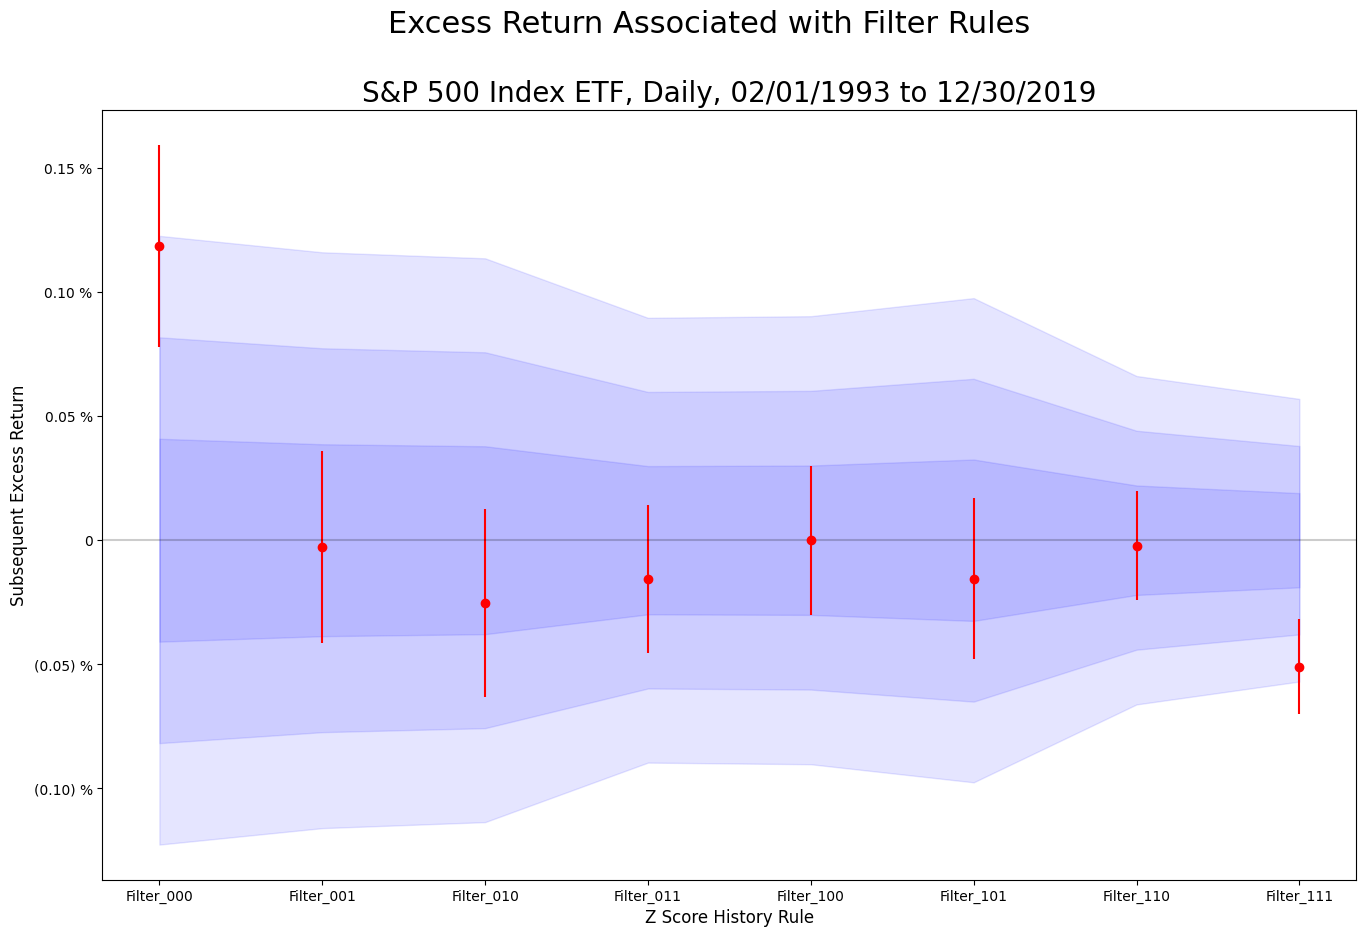

In [8]:
nprint("Fitting GJR-GARCH model with filter rules...")
model=ARX((design:=data.dropna())['Return'],design[fcols:=design.columns[design.columns.str.contains('Filter')]])
model.volatility=GARCH2(0,1,1)
model.distribution=GeneralizedError2()
fit=model.fit(update_freq=0,disp='off')
nprint(fit.summary(),sep='\n')
coefficients=pd.DataFrame([fit.params[fcols],fit.std_err[fcols]]).T

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.errorbar(x:=coefficients.index,y:=coefficients['params'],ye:=coefficients['std_err'],fmt='o',color='red')
plot.axhline(color='black',alpha=0.2)
plot.set_ylabel('Subsequent Excess Return',fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(2))
plot.set_xlabel('Z Score History Rule',fontsize=12)
figure.suptitle(title:='Excess Return Associated with Filter Rules',fontsize=22)
plot.set_title(subtitle:='{:s}, Daily, {:s} to {:s}'.format(sname,data.index[0].strftime("%m/%d/%Y"),data.index[-1].strftime("%m/%d/%Y")),fontsize=20)

for s in range(1,4):
    plot.fill_between(x,-s*ye,y2=s*ye,alpha=0.1,color='blue')

figure.savefig(filename:=(filepath:='/content/drive/MyDrive/')+title+'.png',dpi=300,bbox_inches='tight')
nprint("Saved figure to '{:s}'.".format(filename))

### Fit a Conditional Model to (Filter_000 | Filter_111)

In [10]:
nprint("Fitting a fusion autoregression...")
data['Filter_000|111']=(data['Filter_000'].astype(bool)|data['Filter_111'].astype(bool)).astype(float)*data['Return'].shift()
model=ARX((design:=data.dropna())['Return'],design['Filter_000|111'])
model.volatility=GARCH2(0,1,1)
model.distribution=GeneralizedError2()
fit=model.fit(update_freq=0,disp='off')
nprint(fit.summary(),sep='\n')
nprint("In-sample IC is (%.2f +/- %.2f) %%" % (-data[['Return','Conditional']].replace(zero,np.nan).dropna().corr().iloc[0,1]*hundred,hundred/np.sqrt(data[['Return','Conditional']].replace(zero,np.nan).dropna().shape[0]-three)))

16:38:45 Fitting a fusion autoregression...
16:38:45
                              AR-X - GJR-GARCH Model Results                              
Dep. Variable:                             Return   R-squared:                       0.005
Mean Model:                                  AR-X   Adj. R-squared:                  0.005
Vol Model:                              GJR-GARCH   Log-Likelihood:               -8751.39
Distribution:      Generalized Error Distribution   AIC:                           17514.8
Method:                        Maximum Likelihood   BIC:                           17555.7
                                                    No. Observations:                 6773
Date:                            Fri, Mar 21 2025   Df Residuals:                     6771
Time:                                    16:38:45   Df Model:                            2
                                   Mean Model                                   
                     coef    std err          t

### Formulas for Article

$$
\alpha_t=\mathbb{E}[r_t|\mathcal{I}_s]:s<t
$$

$$
\alpha_t=f(\mathcal{I}_s)
$$

$$
f(\mathcal{I}_s)=\mu+\varphi r_{t-1}+\dots
$$

$$
\lim_{t\rightarrow\infty}\mathbb{E}[\alpha_t]=\mathbb{E}[r_t]
$$

$$
\overline{\{r_s : s<t\}}
$$

$$
\begin{align}
r_t&=\mu+\varphi r_{t-1}+\sigma_t\varepsilon_t\\
\sigma_t^2&=C+B\sigma_{t-1}^2+Dr_{t-1}^2\mathbb{I}[r_{t-1}<0]\\
\varepsilon_t&\sim\mathop{\mathrm{GED}}(\kappa)
\end{align}
$$

$$
\alpha_t=\mu+\chi r_{t-1}\times\left(\mathtt{Filter\_000}_{t-1}+\mathtt{Filter\_111_{t-1}}\right)
$$